In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#if some of the packages are not installed, execute the this cell:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib

# read dataframes

This notebook contains the difference map calculations used for the paper: Stabilization of viral glycoproteins in prefusion conformation using ThermoMPNN with negative state design.

As prerequisites for the successful generation of the difference map, thermostabilty .csv files generated by thermoMPNN are needed for the prefusion and the postfusion state.

In [122]:
df_1 = pd.read_csv('prefusion.csv', sep=',', header=0)
df_2 = pd.read_csv('postfusion.csv', sep=',', header=0)

## compute difference: equation 1

In [127]:
df = df_1.copy()
df['ddG (kcal/mol)'] = df_1['ddG (kcal/mol)'] - df_2['ddG (kcal/mol)']

In [ ]:
alphabet = 'ACDEFGHIKLMNPQRSTVWY'
positions = df['pos'].unique()
arr = np.zeros((len(alphabet), positions.size), dtype=float)

for p_idx, p in enumerate(positions):
    for a_idx, a in enumerate(alphabet):
        arr[a_idx, p_idx] = df.loc[(df['pos'] == p) & (df['mutAA'] == a)]['ddG (kcal/mol)']

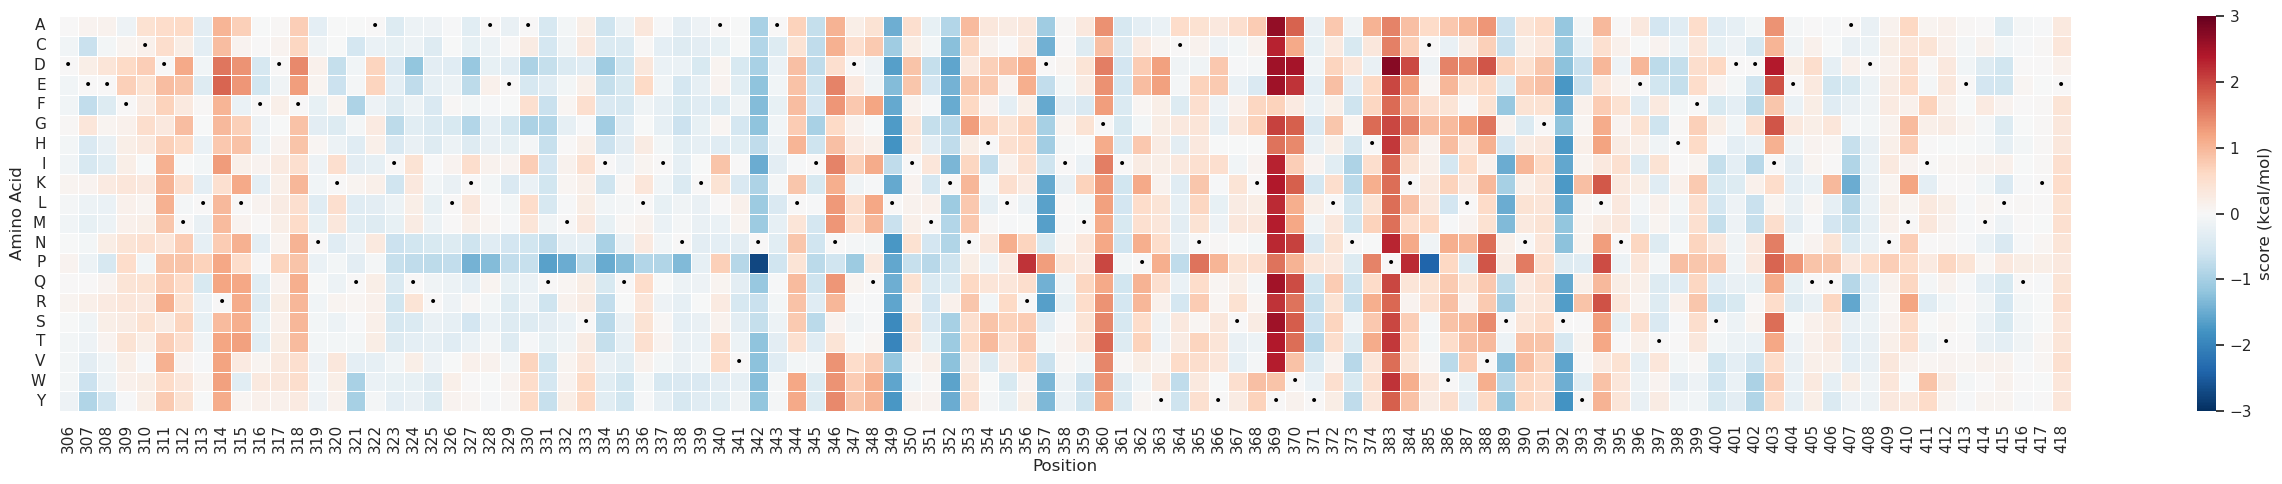

In [131]:
sns.set()
sns.set(rc={"figure.figsize": (positions.size // 4, 5)})
g = sns.heatmap(data=arr, cmap='RdBu_r', center=0, robust=True,
                xticklabels=positions, yticklabels=list(alphabet),
                vmin=-3, vmax=3, linewidth=0.5, cbar_kws={'label': 'ddG (kcal/mol)'})

# Add dots for WT amino acids
for i, p in enumerate(positions):
    wt_aa = df.loc[df['pos'] == p, 'wtAA'].values[0]
    g.text(i + 0.5, alphabet.index(wt_aa) + 0.5, '•', ha='center', va='center', color='black', fontsize=10)

g.set(xlabel='Position', ylabel='Amino Acid')
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

## compute difference map: equation 2

## select the top10 Mutations

In [109]:
df = df.nsmallest(n=40, columns='ddG (kcal/mol)')

In [111]:
df = df[df['wtAA'].apply(lambda x: x != 'C')]
df = df[df['mutAA'].apply(lambda x: x != 'C')]
df = df.drop_duplicates('pos')

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.linewidth'] = 2
plt.figure(figsize=(4, 4))
g = sns.barplot(x='Mutation', y='ddG (kcal/mol)', data=df, width=.5, legend=False)
plt.xticks(rotation=90)
plt.xlim(-0.5, 9.5)
plt.ylabel('ΔΔG / kcal mol⁻¹')
plt.xlabel('position')

In [17]:
df[['Mutation','ddG (kcal/mol)']]

,Mutation,ddG (kcal/mol)
732,N342P,-2.7369
876,L349T,-1.9711
1568,K384K,-1.6987
1030,D357M,-1.6575
512,Q331P,-1.6220
938,K352W,-1.6161
572,I334P,-1.5007
532,M332P,-1.4964
1923,D402E,-1.4515
2003,Q406E,-1.4300


## map average values onto structure

In [ ]:
# if you have pyrosetta installed
import pyrosetta
pyrosetta.init('-mute all')

In [48]:
mean_arr = np.mean(arr, axis=0)
np.savetxt('mean_values.dat', mean_arr)

In [51]:
pose = pyrosetta.pose_from_pdb('prefusion-structure.pdb')

In [52]:
for i in range(1, len(pose.sequence()) + 1):
    for j in range(1, pose.residue(i).natoms() + 1):
        pose.pdb_info().bfactor(i, j, 0)
    # Fill in bfactors
    counter = 0
    for c in range(1, pose.pdb_info().num_chains() + 1):
        chain_start = pose.conformation().chain_begin(c)
        chain_end = pose.conformation().chain_end(c)
        for i in range(chain_start, chain_end + 1):
            if counter < len(mean_arr):
                for j in range(1, pose.residue(i).natoms() + 1):
                    pose.pdb_info().bfactor(i, j, mean_arr[counter])
                counter += 1
    pose.dump_pdb('mapped-prefusion-structure.pdb')

In [ ]:
PENALTY = 10.0

df = df_1.copy()
df['ddG (kcal/mol)'] = df_1['ddG (kcal/mol)'] - df_2['ddG (kcal/mol)']
df['score'] = df['ddG (kcal/mol)'] + PENALTY * np.maximum(0.0, df_1['ddG (kcal/mol)'] - 0.2)

In [ ]:
alphabet = 'ACDEFGHIKLMNPQRSTVWY'
positions = df['pos'].unique()
arr = np.zeros((len(alphabet), positions.size), dtype=float)

for p_idx, p in enumerate(positions):
    for a_idx, a in enumerate(alphabet):
        arr[a_idx, p_idx] = df.loc[(df['pos'] == p) & (df['mutAA'] == a)]['score']

In [ ]:
sns.set()
sns.set(rc={"figure.figsize": (positions.size // 4, 5)})
g = sns.heatmap(data=arr, cmap='RdBu_r', center=0, robust=True,
                xticklabels=positions, yticklabels=list(alphabet),
                vmin=-3, vmax=3, linewidth=0.5, cbar_kws={'label': 'score (kcal/mol)'})

# Add dots for WT amino acids
for i, p in enumerate(positions):
    wt_aa = df.loc[df['pos'] == p, 'wtAA'].values[0]
    g.text(i + 0.5, alphabet.index(wt_aa) + 0.5, '•', ha='center', va='center', color='black', fontsize=10)

g.set(xlabel='Position', ylabel='Amino Acid')
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df = df.nsmallest(n=40, columns='score')

In [ ]:
df = df[df['wtAA'].apply(lambda x: x != 'C')]
df = df[df['mutAA'].apply(lambda x: x != 'C')]
df = df.drop_duplicates('pos')

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.linewidth'] = 2
plt.figure(figsize=(4, 4))
g = sns.barplot(x='Mutation', y='score', data=df, width=.5, legend=False)
plt.xticks(rotation=90)
plt.xlim(-0.5, 9.5)
plt.ylabel('ΔΔG / kcal mol⁻¹')
plt.xlabel('position')